Comparing merge-tests between 3.4 and 3.6. Day long simulation.

* Rivers turned off, key_ldfslp turned off

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as NC
import numpy as np
import scipy.interpolate as sp
import math

import datetime

from salishsea_tools import stormtools, nc_tools, viz_tools

In [2]:
#load up the bathymetry. 
grid = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
bathy = grid.variables['Bathymetry'][:,:]
X = grid.variables['nav_lon'][:,:]
Y = grid.variables['nav_lat'][:,:]

In [3]:
#load in the datas. Trying something new with dict objects...

#first run (3.4)
r1 = 'no_river';
runname1 = '/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/' + r1 
print runname1

#second run (3.6)
r2 = 'three-six'
runname2 = '/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/'
print runname2

runs = {r1: runname1, r2: runname2}


/data/nsoontie/MEOPAR/SalishSea/results/merge-tests/merg2015/no_river
/ocean/sallen/allen/research/MEOPAR/nemo-3.6-code/NEMOGCM/CONFIG/SalishSea/EXP00/


In [4]:
fUs={}; fVs={}; fTs={}
for key, path in runs.iteritems():
    if key == r1:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121214_grid_T.nc','r');
    else:
        fUs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_U.nc','r');
        fVs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_V.nc','r');
        fTs[key] = NC.Dataset(path +'/SalishSea_1h_20121214_20121215_grid_T.nc','r');

Show info about the files

In [5]:
for key in runs:
    print key
    nc_tools.show_dataset_attrs(fUs[key])

three-six
file format: NETCDF4
name: SalishSea_1h_20121214_20121215
description: ocean U grid variables
conventions: CF-1.1
production: An IPSL model
timeStamp: 2015-Jul-08 07:54:45 PDT
no_river
file format: NETCDF4
Conventions: CF-1.1
production: An IPSL model
TimeStamp: 06/07/2015 18:27:09 -0700
file_name: SalishSea_1h_20121214_20121214_grid_U.nc
history: Mon Jul  6 18:29:17 2015: ncks -4 -L4 -O SalishSea_1h_20121214_20121214_grid_U.nc SalishSea_1h_20121214_20121214_grid_U.nc
NCO: 4.4.5


In [6]:
for key in runs:
    print key
    nc_tools.show_variable_attrs(fUs[key])

three-six
<type 'netCDF4.Variable'>
float32 nav_lat(y, x)
    axis: Y
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling off

<type 'netCDF4.Variable'>
float32 nav_lon(y, x)
    axis: X
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    nav_model: grid_U
unlimited dimensions: 
current shape = (898, 398)
filling off

<type 'netCDF4.Variable'>
float32 depthu(depthu)
    axis: Z
    long_name: Vertical U levels
    units: m
    positive: down
unlimited dimensions: 
current shape = (40,)
filling off

<type 'netCDF4.Variable'>
float32 vozocrtx(time_counter, depthu, y, x)
    long_name: ocean current along i-axis
    units: m/s
    online_operation: average
    interval_operation: 10s
    interval_write: 1h
    _FillValue: 1e+20
    missing_value: 1e+20
    coordinates: time_centered depthu nav_lon nav_lat
unlimited dimensions: time_counter
current shape = 

Different sizes because initial is 48 hours. 

In [7]:
#U,V,SSH,Salinity,Temperature
Us={}; Vs={}; Es={}; Ss={}; Ts={}; Ds={}
tims = {}
t_orig = {}
tim_count={}

for key in runs:
    Us[key] = fUs[key].variables['vozocrtx']
    Vs[key] = fVs[key].variables['vomecrty']
    Es[key] = fTs[key].variables['sossheig']
    Ss[key] = fTs[key].variables['vosaline']
    Ts[key] = fTs[key].variables['votemper']
    Ds[key] = fTs[key].variables['deptht']
    tim_count[key] = fUs[key].variables['time_counter']
    
t_orig[r1] = datetime.datetime.strptime(
                    tim_count[r1].time_origin.title(), ' %Y-%b-%d %H:%M:%S')
t_orig[r2] = datetime.datetime.strptime(
                tim_count[r2].time_origin.title(), '%Y-%m-%d %H:%M:%S')


#Comparison plots

Quick look at surface fields near the start adn end of first day

In [8]:
def plot_variable(t,depthlevel,var, var_name,vmin=-3,vmax=3,diffmin=-0.1, diffmax=0.1,figsize=(15,5),ssh_flag=False):
    #plot
    fig, axs=plt.subplots(1,3,figsize=figsize)
    for key,ax in zip(runs,axs[0:2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        if ssh_flag:
            mesh=ax.pcolormesh(var[key][t,:,:],vmin=vmin,vmax=vmax)
        else:
            mesh=ax.pcolormesh(var[key][t,depthlevel,:,:],vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)
    ax=axs[2]
    if ssh_flag:
        diff = var[r1][t,:,:]-var[r2][t,:,:]
    else:
        diff = var[r1][t,depthlevel,:,:]-var[r2][t,depthlevel,:,:]
    mesh = ax.pcolormesh(diff, vmin=diffmin, vmax=diffmax, cmap = 'bwr')
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    viz_tools.plot_land_mask(ax,grid,isobath=depthlevel)

Initial time, surface

Time = 0, depth level = 0


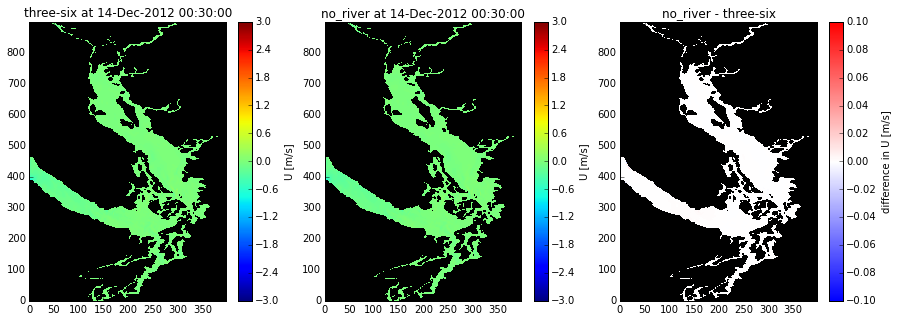

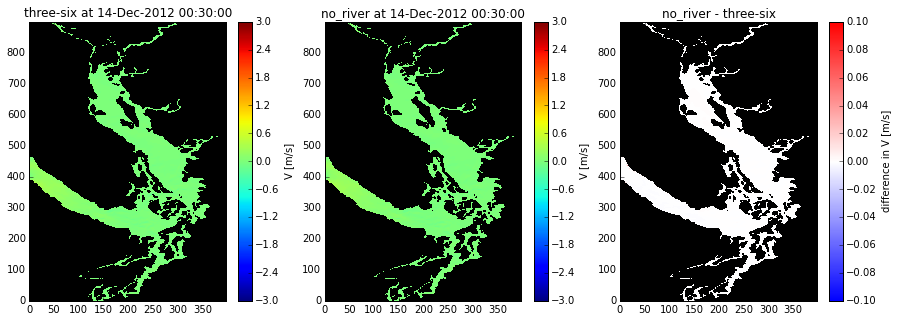

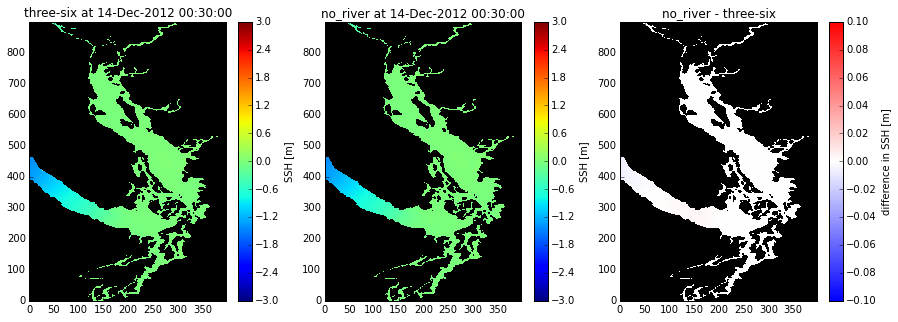

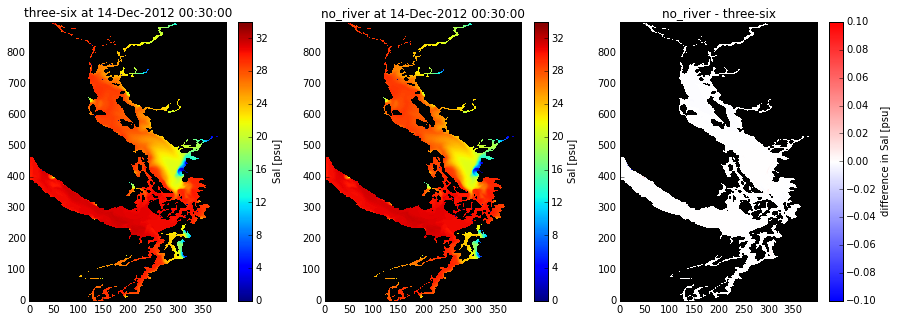

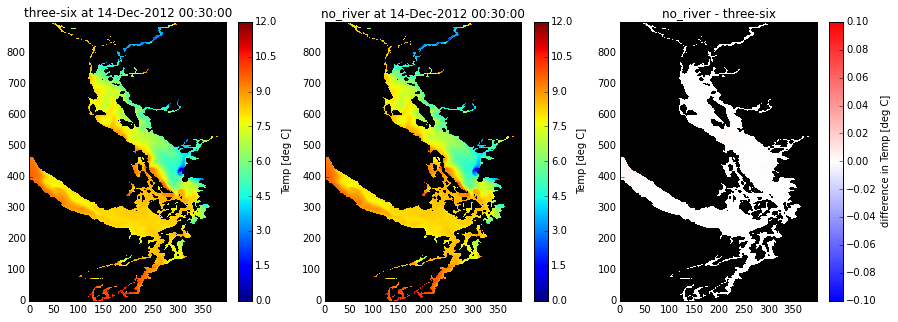

In [9]:
t=0
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

Minor differences in the U/V fields at the SJdF open boundary.  
2015/06/06: No differences at the 0.1 level in any fields.

Time = 23, depth level = 0


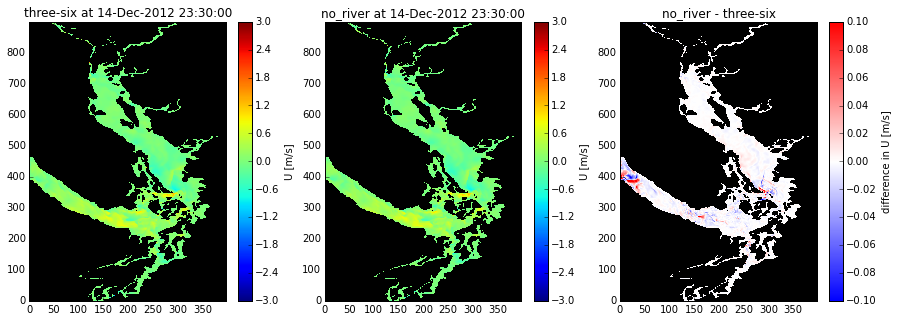

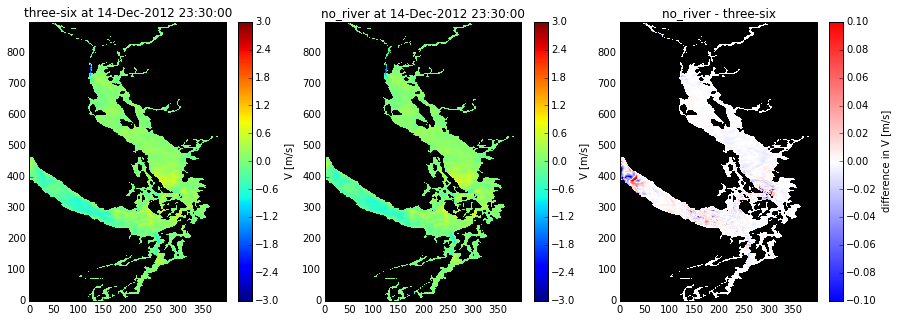

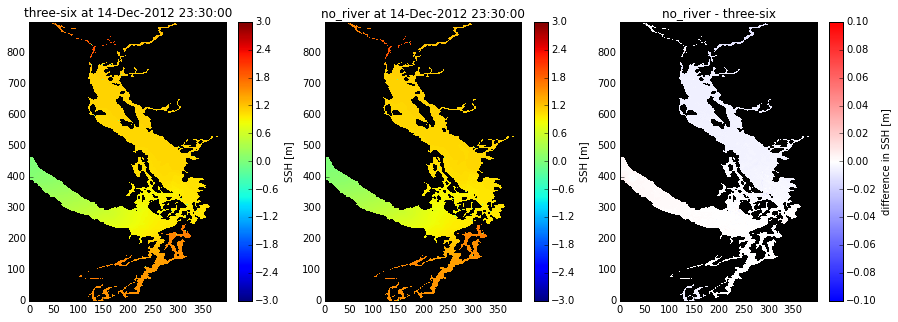

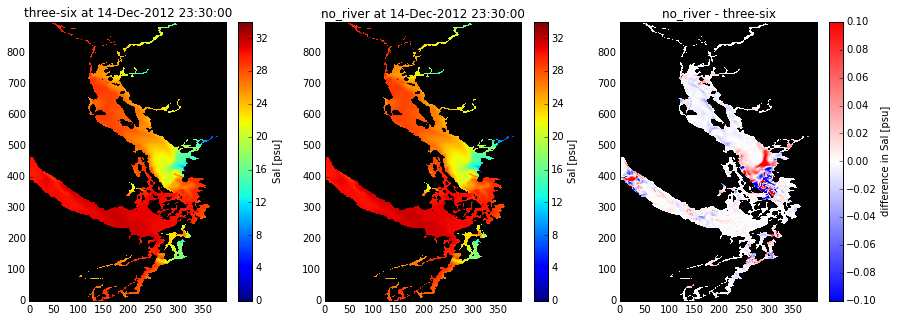

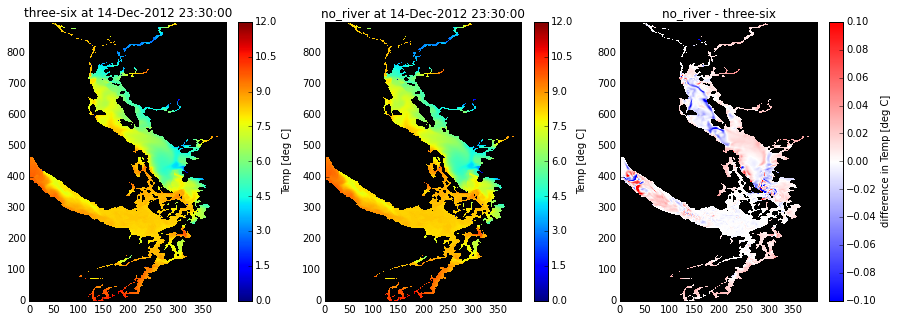

In [10]:
t=23
depthlevel=0

print 'Time = {}, depth level = {}'.format(t,depthlevel)
plot_variable(t,depthlevel,Us,'U [m/s]')
plot_variable(t,depthlevel,Vs,'V [m/s]')
plot_variable(t,depthlevel,Es,'SSH [m]', ssh_flag=True)
plot_variable(t,depthlevel,Ss,'Sal [psu]', vmin=0,vmax=34)
plot_variable(t,depthlevel,Ts,'Temp [deg C]', vmin=0,vmax=12)

* Differences in U/V at SJdF are larger. 
* The SSH is pretty much the same between the two.
* Differences in temp/salinity in plume and in SJdF 
2015/06/06
* correcting the sea surface turbulence parameters has not changed the mixing in the plume area

# Profiles

In [11]:
def compare_profile(var,var_name, i,j,t,zmin=0,zmax=400,vmin=0,vmax=34):
    """Function to compare a variable over depth at point i,j and time t.
    Plots each sim on the same axis and then their difference over depth"""

    fig,axs=plt.subplots(1,2,figsize=(10,5))
    ax=axs[0]
    for key in runs:
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        ax.plot(var[key][t,:,j,i],Ds[key], '-o',label=key)
    ax.set_title(out.strftime('%d-%b-%Y %H:%M:%S'))
    ax.set_xlabel(var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])
    ax.set_xlim([vmin,vmax])
    ax.legend(loc=0)
    ax=axs[1]
    #difference    
    diff = var[r1][t,:,j,i]-var[r2][t,:,j,i]
    ax.plot(diff,Ds[key], '-ro')
    ax.set_title('Difference: ' +r1+' - ' +r2)
    ax.set_xlabel('Difference in ' + var_name)
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([zmax,zmin])

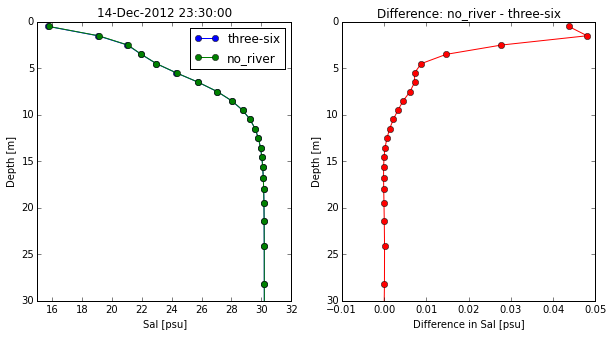

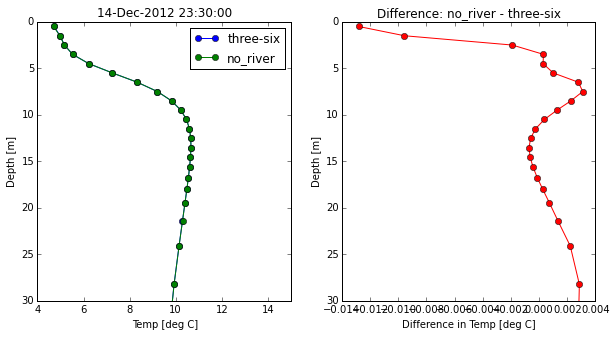

In [12]:
tp = 23
ip = 300
jp = 450
zmax=30
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=4,vmax=15)

* At a point where the 3.4 is much saltier in the surface, 3.6 is showing less mixing in the top 10 m.

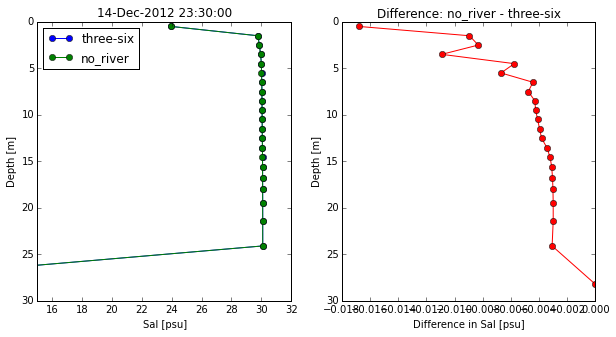

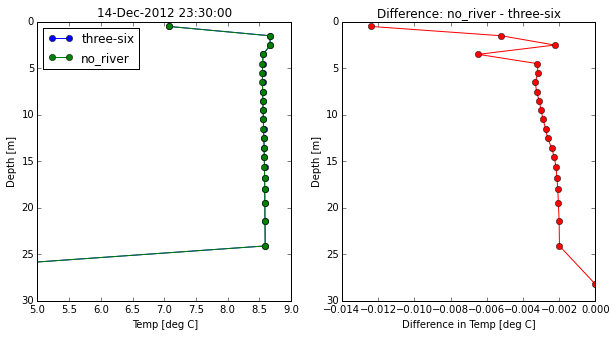

In [13]:
tp = 23
ip = 300
jp = 400
zmax=30
compare_profile(Ss,'Sal [psu]', ip,jp,tp,zmin=0,zmax=zmax,vmin=15,vmax=32)
compare_profile(Ts,'Temp [deg C]', ip,jp,tp,zmin=0,zmax=zmax,vmin=5,vmax=9)


* At a point where the 3.4 is much fresher in the surface, 3.6 is showing saltier down to 30 m.

#Differences

Calculate simple staistics on the differences between fields. min/max/mean...

In [14]:
def summarize_differences(var,var_name,imin=0,imax=396,jmin=0,jmax=896):
    diff = var[r1][0:24,...,jmin:jmax+1,imin:imax+1]-var[r2][...,jmin:jmax+1,imin:imax+1]
    inds_min = np.argmin(diff); inds_min=np.unravel_index(inds_min,diff.shape)
    inds_max = np.argmax(diff); inds_max=np.unravel_index(inds_max,diff.shape)
    print var_name
    print 'min diff: {0:.3}, index {1}'.format(diff.min(),inds_min)
    print 'max diff: {0:.3}, index {1}'.format(diff.max(),inds_max)
    print 'mean diff {0:.3}'.format(diff.mean())

In [15]:
variables = {'U [m/s]': Us,  'V [m/s]': Vs, 'SSH [m]': Es, 'Sal [psu]': Ss, 'Temp [deg C]': Ts}
for key in variables:
    summarize_differences(variables[key],key)

V [m/s]
min diff: -0.818, index (5, 0, 433, 2)
max diff: 0.633, index (5, 21, 406, 1)
mean diff -4.48e-06
Temp [deg C]
min diff: -0.778, index (18, 0, 368, 294)
max diff: 0.999, index (11, 0, 359, 302)
mean diff 7.49e-05
SSH [m]
min diff: -2.22, index (21, 896, 41)
max diff: 2.68, index (3, 896, 41)
mean diff -0.00092
U [m/s]
min diff: -1.08, index (4, 1, 430, 1)
max diff: 0.759, index (19, 3, 400, 1)
mean diff -6.42e-06
Sal [psu]
min diff: -2.58, index (18, 0, 368, 294)
max diff: 3.19, index (14, 0, 356, 307)
mean diff 2.08e-06


* Mean diff is perhaps unfair because the fields aren't masked. So there are a whole lot of zeros
* U/V have largest differences near the beginning of simulatio, and JdF open boundary
* Large differences in ssh are probaly because of how the open boundary is treated. 3.4 has an extra layer of zeros at each boundary on the T grid. Perhpas this can explain the U/V differences too?
* Largest temp and salinity difference looks to be just after Boundary Pass at the surface.

Exclude layer surrounding the open boundaries

In [16]:
imin=2; imax=396
jmin=2; jmax=895
for key in variables:
    summarize_differences(variables[key],key,imin,imax,jmin,jmax)

V [m/s]
min diff: -0.818, index (5, 0, 431, 0)
max diff: 0.504, index (5, 25, 430, 0)
mean diff -3.7e-06
Temp [deg C]
min diff: -0.778, index (18, 0, 366, 292)
max diff: 0.999, index (11, 0, 357, 300)
mean diff 7.55e-05
SSH [m]
min diff: -0.103, index (9, 767, 119)
max diff: 0.0639, index (16, 771, 118)
mean diff -0.000933
U [m/s]
min diff: -0.467, index (20, 26, 405, 0)
max diff: 0.672, index (4, 0, 425, 0)
mean diff -6.24e-06
Sal [psu]
min diff: -2.58, index (18, 0, 366, 292)
max diff: 3.19, index (14, 0, 354, 305)
mean diff 2.07e-06


#Bounday conditions on SSH

How do the ssh/u/v near the boundaries compare?

In [17]:
sshs={}
us={}
vs={}
i=1
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
        

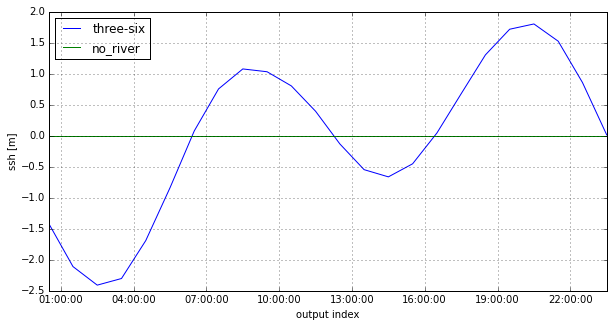

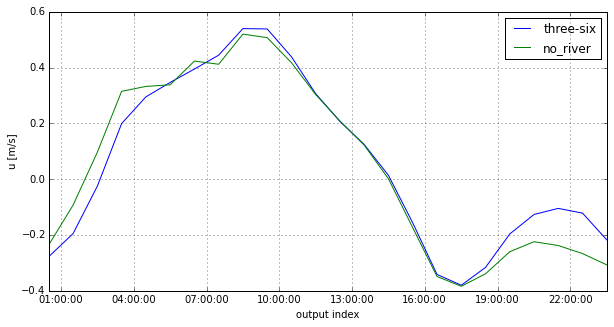

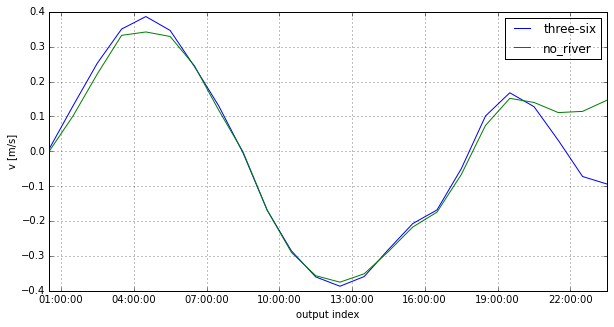

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Why is second index zero in initial but not three-six.

Next to boundary

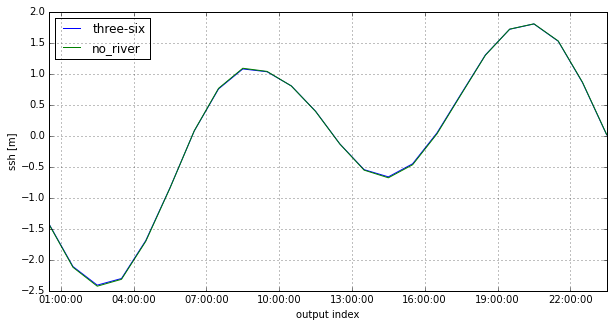

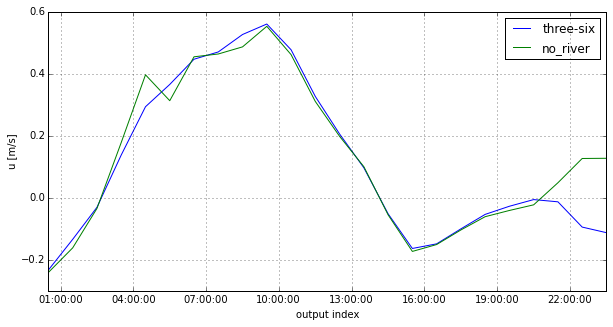

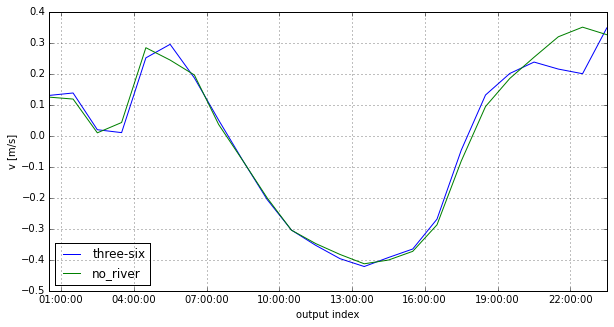

In [19]:
sshs={}
us={}
vs={}
i=2
j=450
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

North

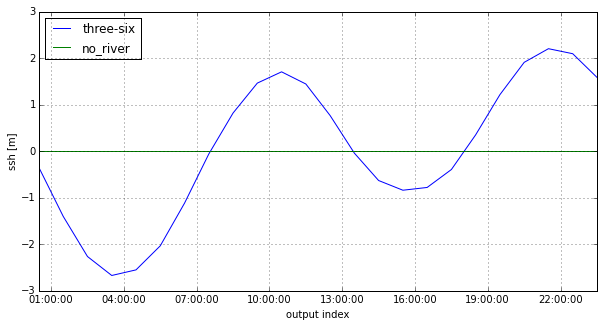

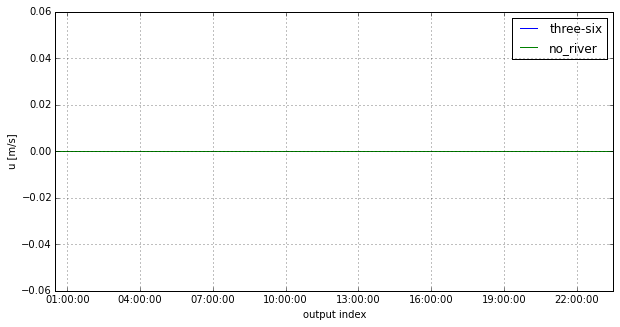

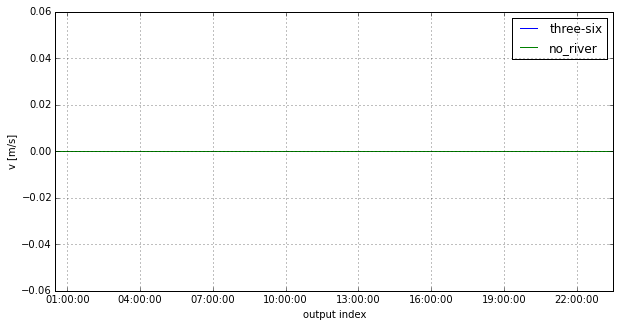

In [20]:
sshs={}
us={}
vs={}
i=50
j=896
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Same here. At the north, initial has two points on the T grid that are zero...

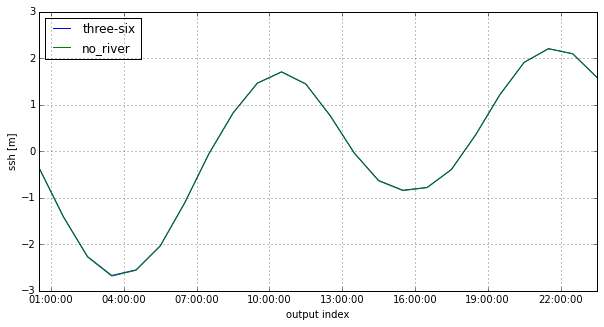

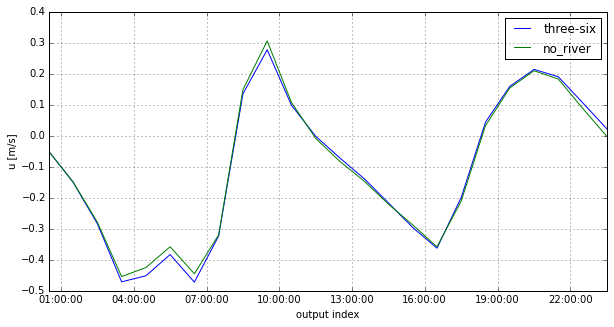

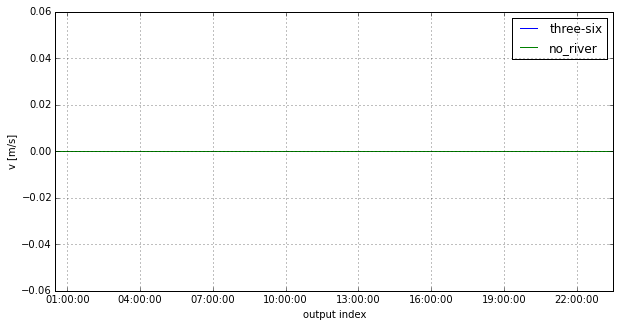

In [21]:
sshs={}
us={}
vs={}
i=50
j=895
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

Phases align!

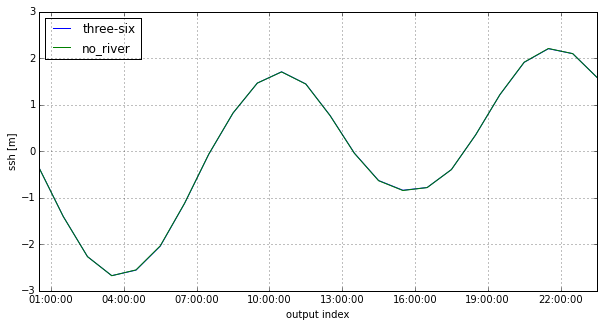

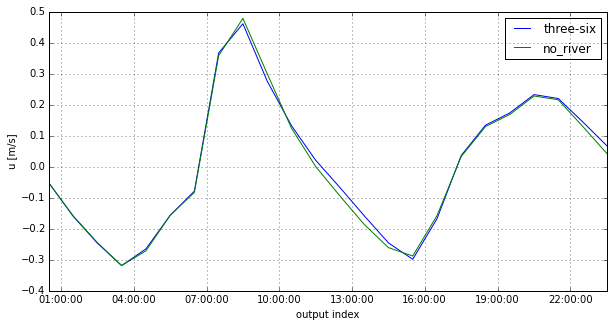

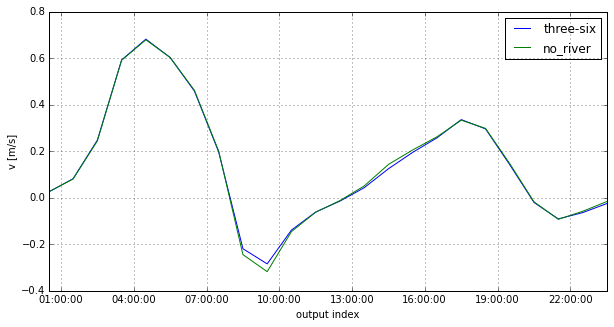

In [22]:
sshs={}
us={}
vs={}
i=50
j=894
dtimes={}

for key in runs:
    sshs[key] = fTs[key].variables['sossheig'][:,j,i]
    us[key] = fUs[key].variables['vozocrtx'][:,0,j,i]
    vs[key] = fVs[key].variables['vomecrty'][:,0,j,i]
    time_count = fTs[key].variables['time_counter'][:]
    dtimes[key]= [t_orig[key]+datetime.timedelta(seconds=t) for t in time_count]
    
fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],sshs[key],label=key)
ax.set_ylabel('ssh [m]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],us[key],label=key)
ax.set_ylabel('u [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

fig,ax=plt.subplots(1,1,figsize=(10,5))

for key in runs:
    ax.plot(dtimes[key],vs[key],label=key)
ax.set_ylabel('v [m/s]')
ax.set_xlabel('output index')
ax.legend(loc=0)
ax.grid()

# Closer look at currents at SJdF boundary

Compare fields over depth and along the JdF boundary

In [23]:
def compare_boundary(var, var_name, irange, jrange, t,vmin=-1,vmax=1,diffmin=-0.5,diffmax=0.5):
    fig,axs=plt.subplots(1,3,figsize=(15,3))
    
    for ax, key in zip(axs[0:2],[r1,r2]):
        tims = tim_count[key][t]
        out= t_orig[key] + datetime.timedelta(seconds=tims)
        masked_var = np.ma.masked_values(var[key][t,:,jrange,irange],0)
        mesh=ax.pcolormesh(masked_var,vmin=vmin,vmax=vmax)
        ax.set_title('{} at {}'.format(key,out.strftime('%d-%b-%Y %H:%M:%S')))
        cbar = plt.colorbar(mesh,ax=ax)
        cbar.set_label(var_name)
        ax.invert_yaxis()

    ax=axs[2]
    diff = var[r1][t,:,jrange,irange]-var[r2][t,:,jrange,irange]
    diff=np.ma.masked_values(diff,0)
    mesh = ax.pcolormesh(diff,vmin=diffmin,vmax=diffmax)
    ax.set_title(r1+' - ' +r2)
    cbar = plt.colorbar(mesh,ax=ax)
    cbar.set_label('difference in ' +var_name)
    ax.invert_yaxis()

Early time

Mouth of JdF at t = 0


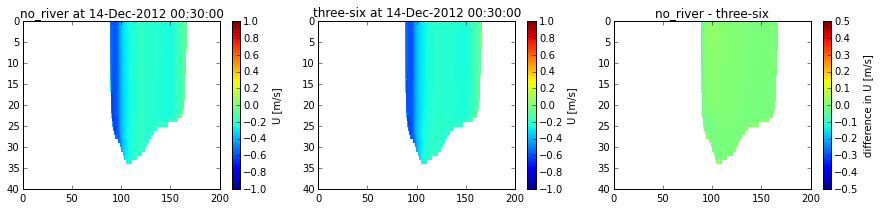

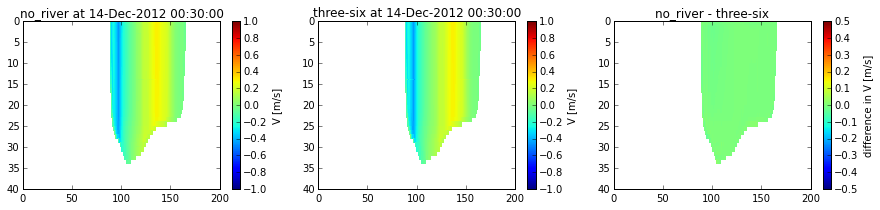

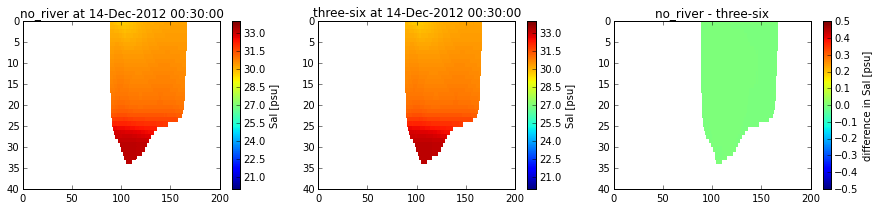

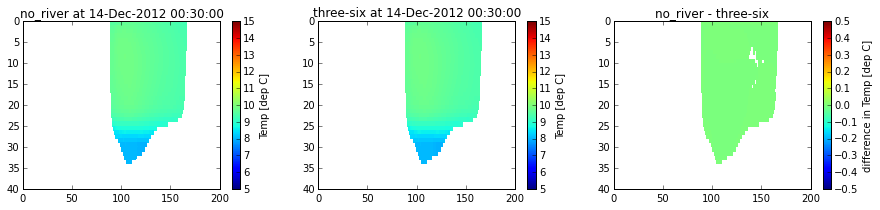

In [24]:
t=0
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Max difference time

Mouth of JdF at t = 5


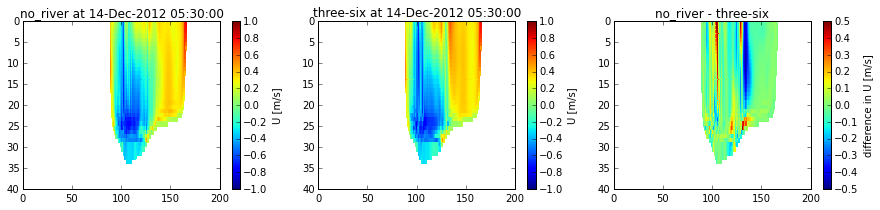

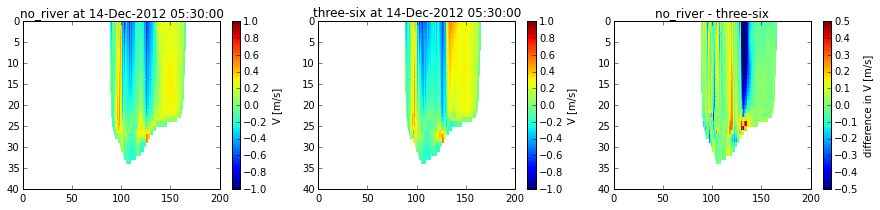

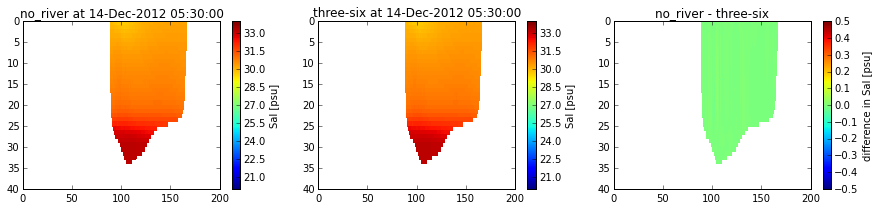

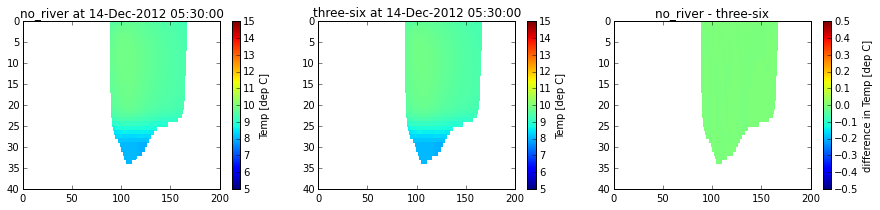

In [25]:
t=5
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)

Last time

Mouth of JdF at t = 23


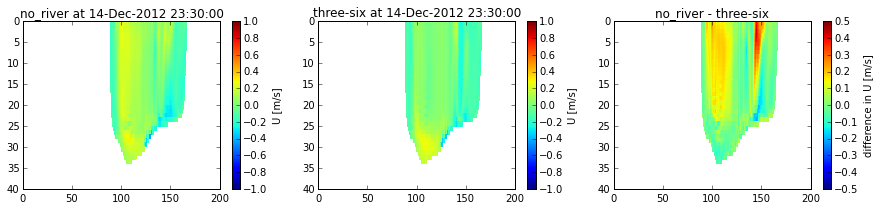

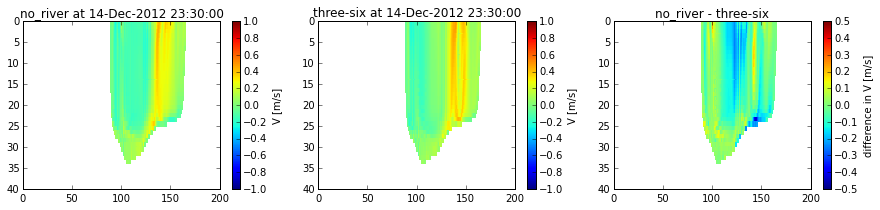

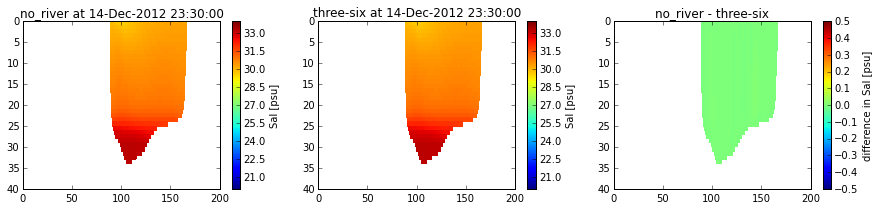

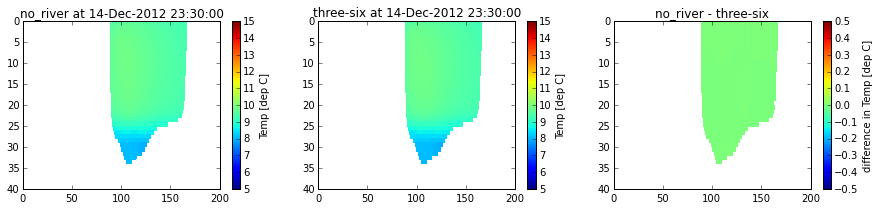

In [26]:
t=23
compare_boundary(Us,'U [m/s]', 2, np.arange(300,500), t)
compare_boundary(Vs,'V [m/s]', 2, np.arange(300,500), t)
compare_boundary(Ss,'Sal [psu]', 2, np.arange(300,500), t,vmin=20,vmax=34)
compare_boundary(Ts,'Temp [dep C]', 2, np.arange(300,500), t,vmin=5,vmax=15)

print 'Mouth of JdF at t = {}'.format(t)